# 95-865: Clustering on Images, and a Sketch of How to Make Sense of the Clusters

Author: George H. Chen (georgechen [at symbol] cmu.edu)

We revisit the MNIST handwritten digits example that we saw earlier in the course with t-SNE. We will be looking at clustering techniques as well some visualizations to make sense of the clusters.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = 'retina'  # if you use a Mac with Retina display

# these next two lines are needed on my old Intel Mac laptop due to some weird software update issue and also a memory issue
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '1'

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

train_dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)
images = np.array([image.numpy() for image, label in train_dataset])

In [3]:
num_images = images.shape[0]
feature_vectors = images.reshape(num_images, -1)
print(feature_vectors.shape)

(60000, 784)


Recall that we can get the labels for all images:

In [4]:
labels = np.array([label for image, label in train_dataset])
print("The labels are:", np.unique(labels))  # note that np.unique() finds the unique elements *and also sorts them*

The labels are: [0 1 2 3 4 5 6 7 8 9]


For simplicity, in this demo, we use a subsample consisting of 5000 of the images. We use the same subsampling strategy from an earlier lecture (the subsample is chosen without replacement).

In [5]:
np.random.seed(0)
random_sample = np.random.permutation(num_images)[:5000]

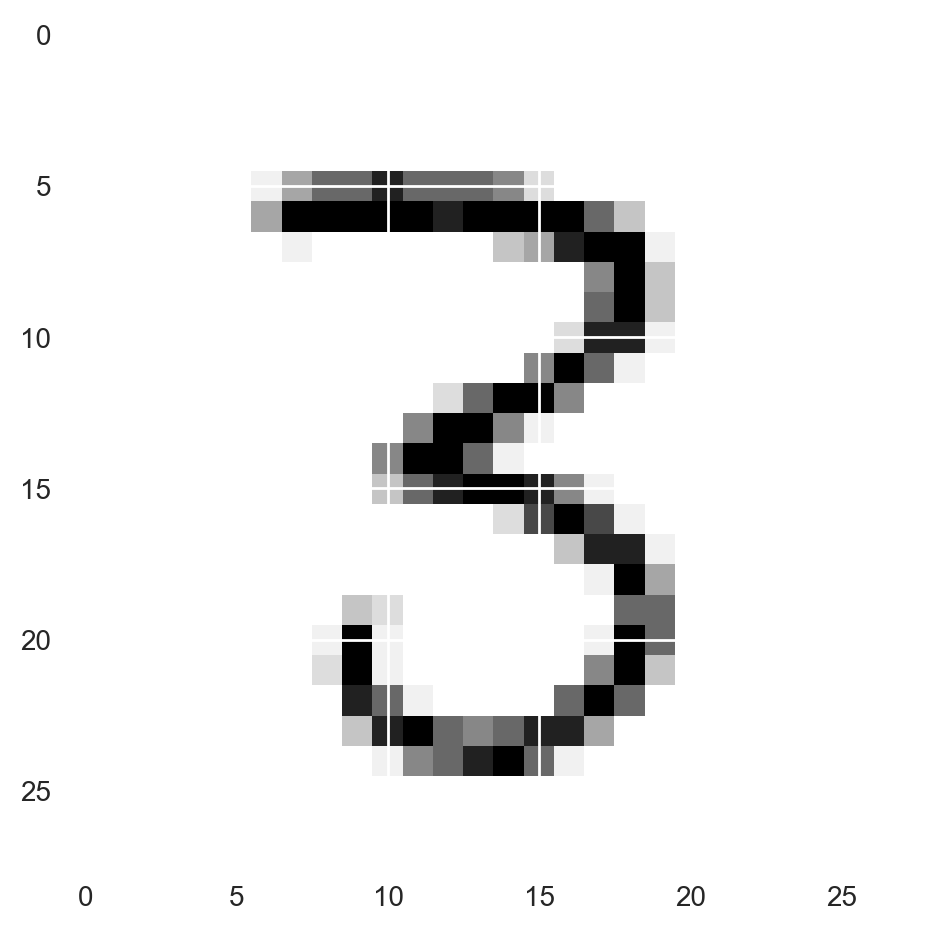

In [6]:
plt.imshow(feature_vectors[np.random.randint(num_images)].reshape(28, 28))

## Clustering in the original space with k-means

Let's first cluster in the original high-dimensional space with k-means. We first import the library from sklearn.

In [7]:
X = feature_vectors[random_sample]

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=10, n_init=10, random_state=0)

In [8]:
kmeans.cluster_centers_.shape

(10, 784)

Note that each cluster center actually corresponds to an image! We visualize these cluster centers momentarily. Let's first take a look at cluster assignments.

Recall that to get the cluster assignments for a collection of data points, we call the method "predict".

In [9]:
kmeans_cluster_assignments = kmeans.predict(X)

<font color='#FF7659'>**How do we figure out which points are in cluster 0?**</font>

In [10]:
X[kmeans_cluster_assignments == 0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

<font color='#FF7659'>**Does cluster 0 actually correspond to digit 0?**</font>

Hopefully it makes sense that the answer is, in general, **no**. K-means does not actually use the labels during the model fitting procedure. As such, it does not know what "digit 0" means. Moreover, the ordering of clusters that it determines is in an arbitrary order.

Let's find out what cluster 0 actually corresponds to in this particular case. For instance, we can plot what the average image is across images in cluster 0.

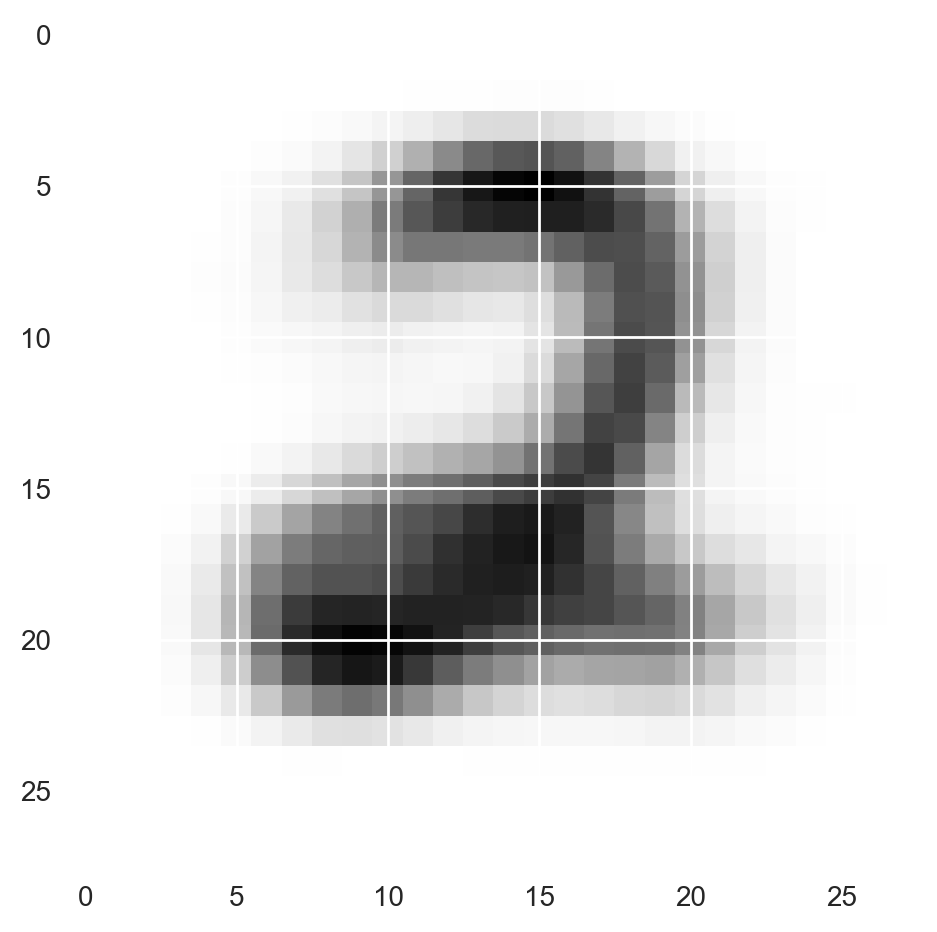

In [11]:
plt.imshow(X[kmeans_cluster_assignments == 0].mean(axis=0).reshape(28, 28))

Another thing we can do is plot the cluster center estimated by k-means for cluster 0.

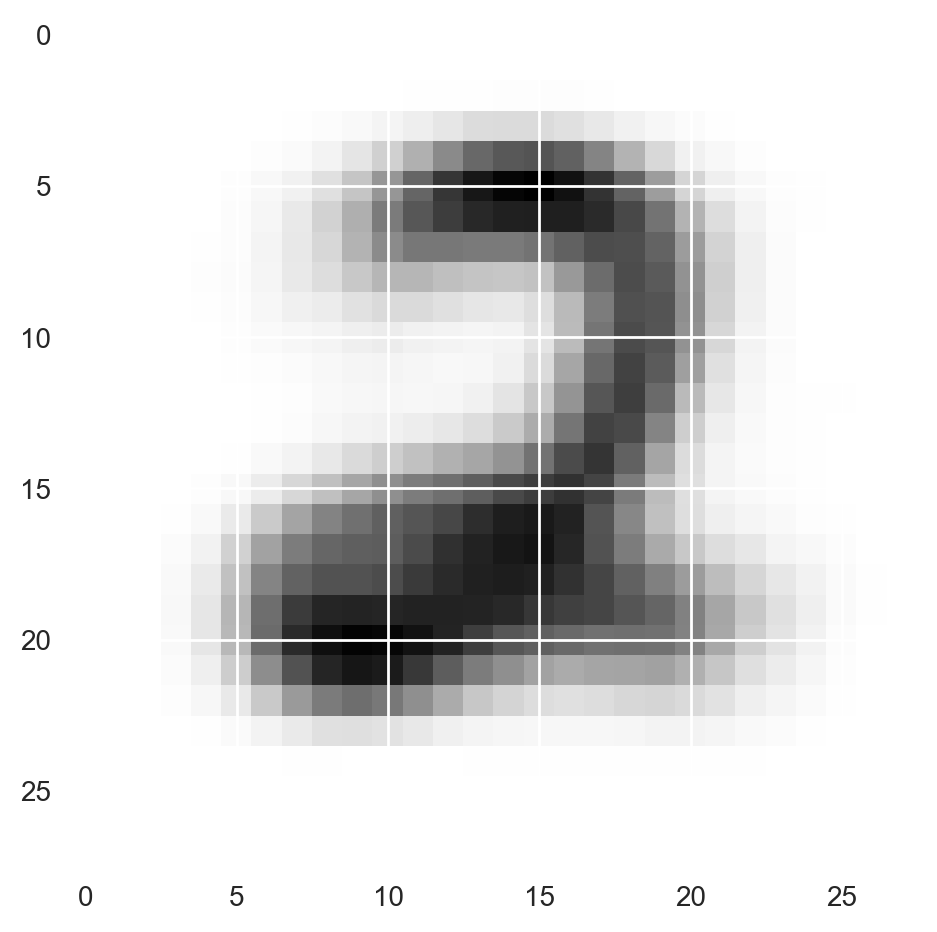

In [12]:
plt.imshow(kmeans.cluster_centers_[0].reshape(28, 28))

Let's now visualize all the cluster centers, not just the one for cluster 0.

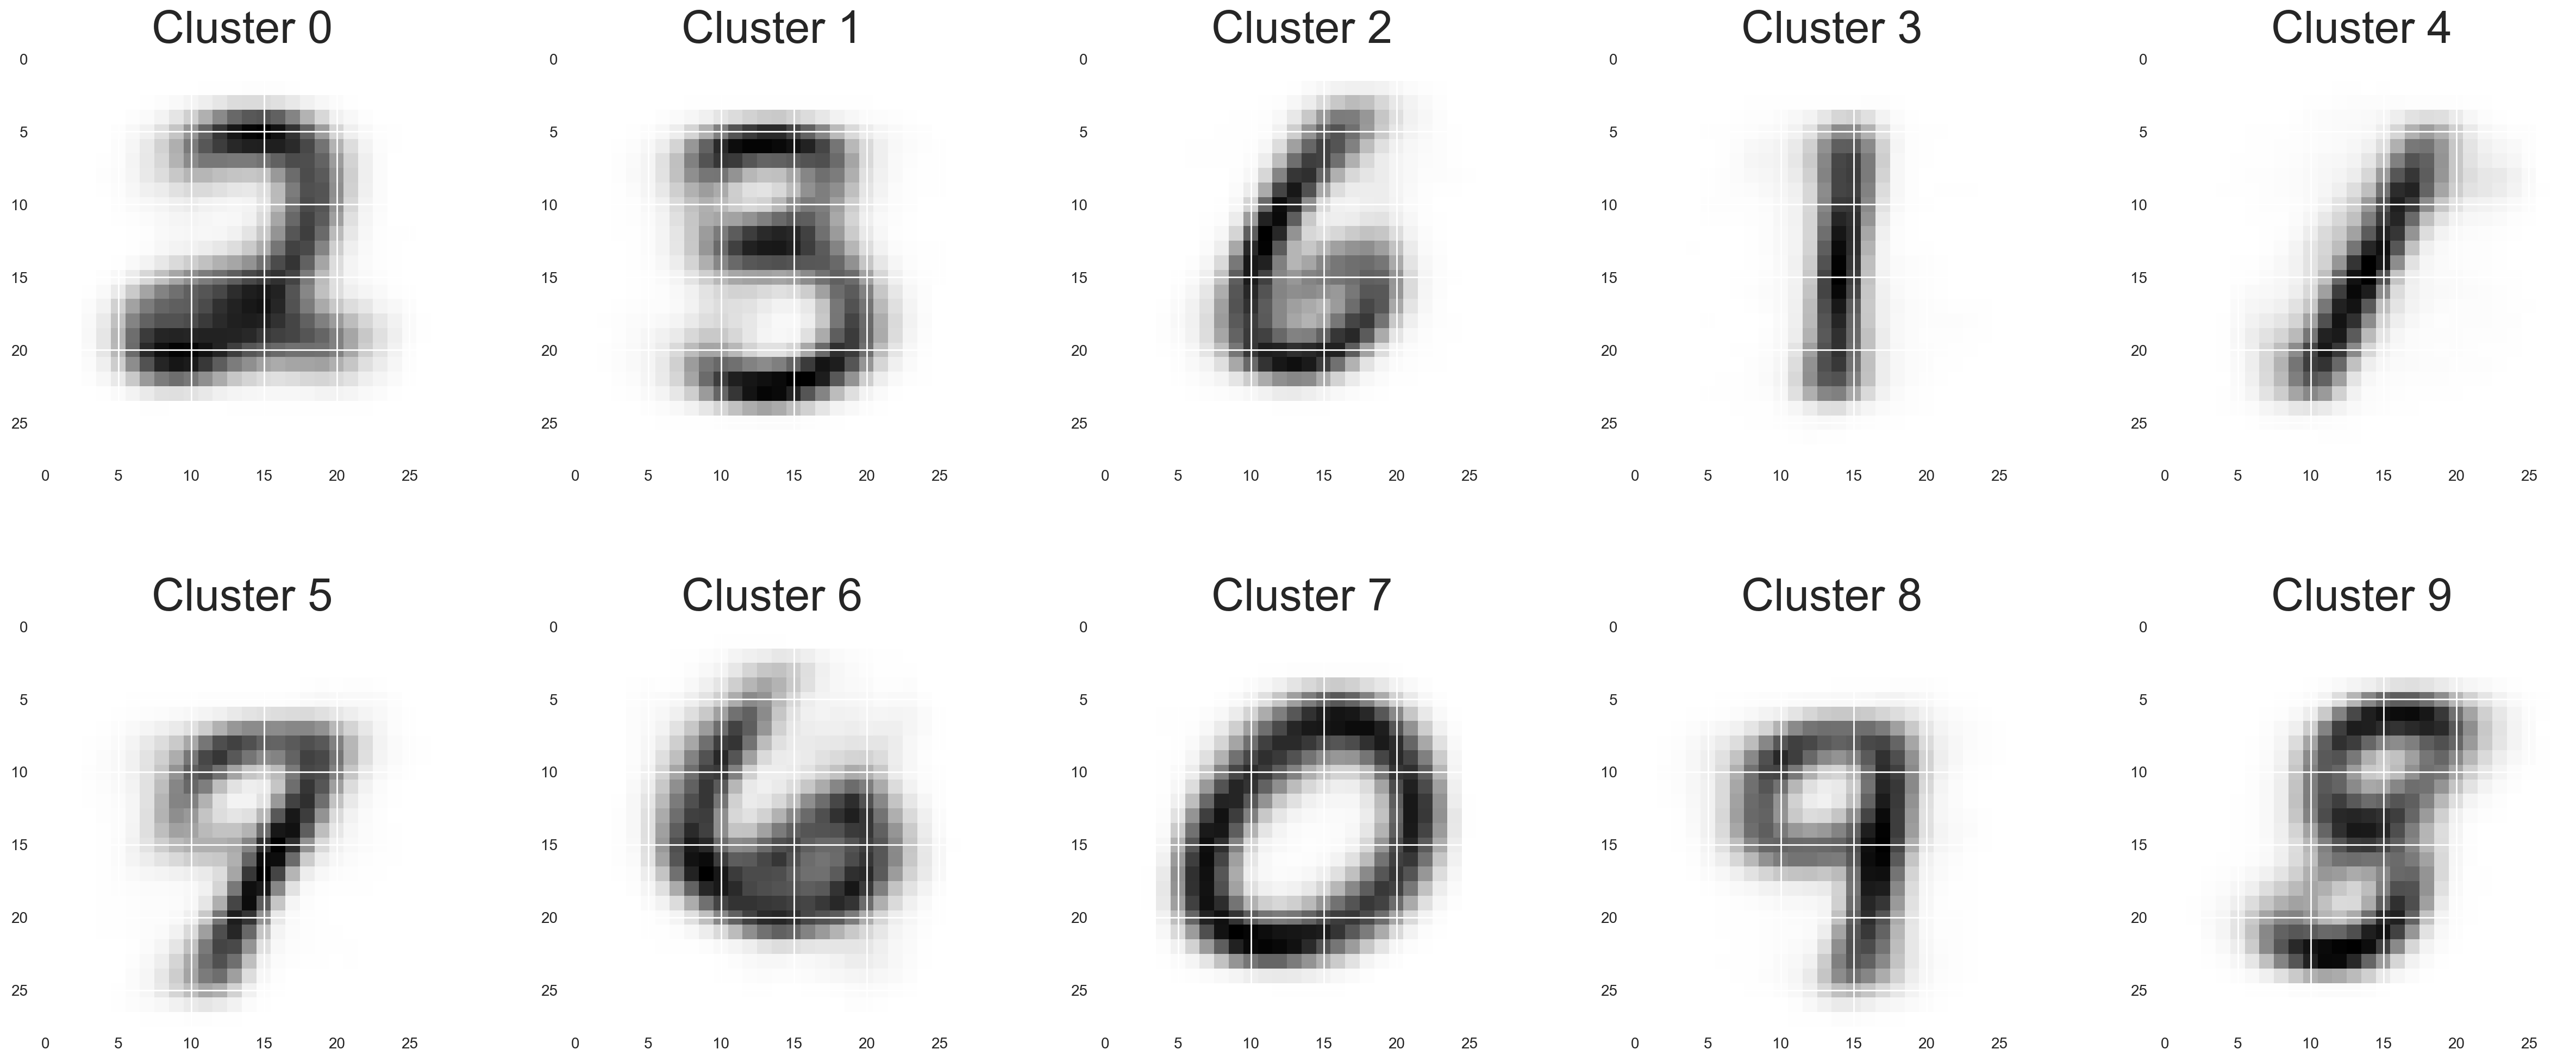

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(30, 12))
axes = axes.flatten()
for cluster_idx in range(10):
    ax = axes[cluster_idx]
    ax.imshow(kmeans.cluster_centers_[cluster_idx].reshape(28, 28))
    ax.set_title('Cluster ' + str(cluster_idx), fontsize=30)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # adds some white space between subplots

It's immediately clear that k-means wasn't able to get all 10 digits as their own clusters!

**Another visualization strategy:** we can figure out which images are closest to each cluster center.

Let's look at the top 20 images closest to the cluster with index 7 above.

In [14]:
distances = np.array([np.linalg.norm(point - kmeans.cluster_centers_[7]) for point in X])
sorted_indices = np.argsort(distances)[:20]

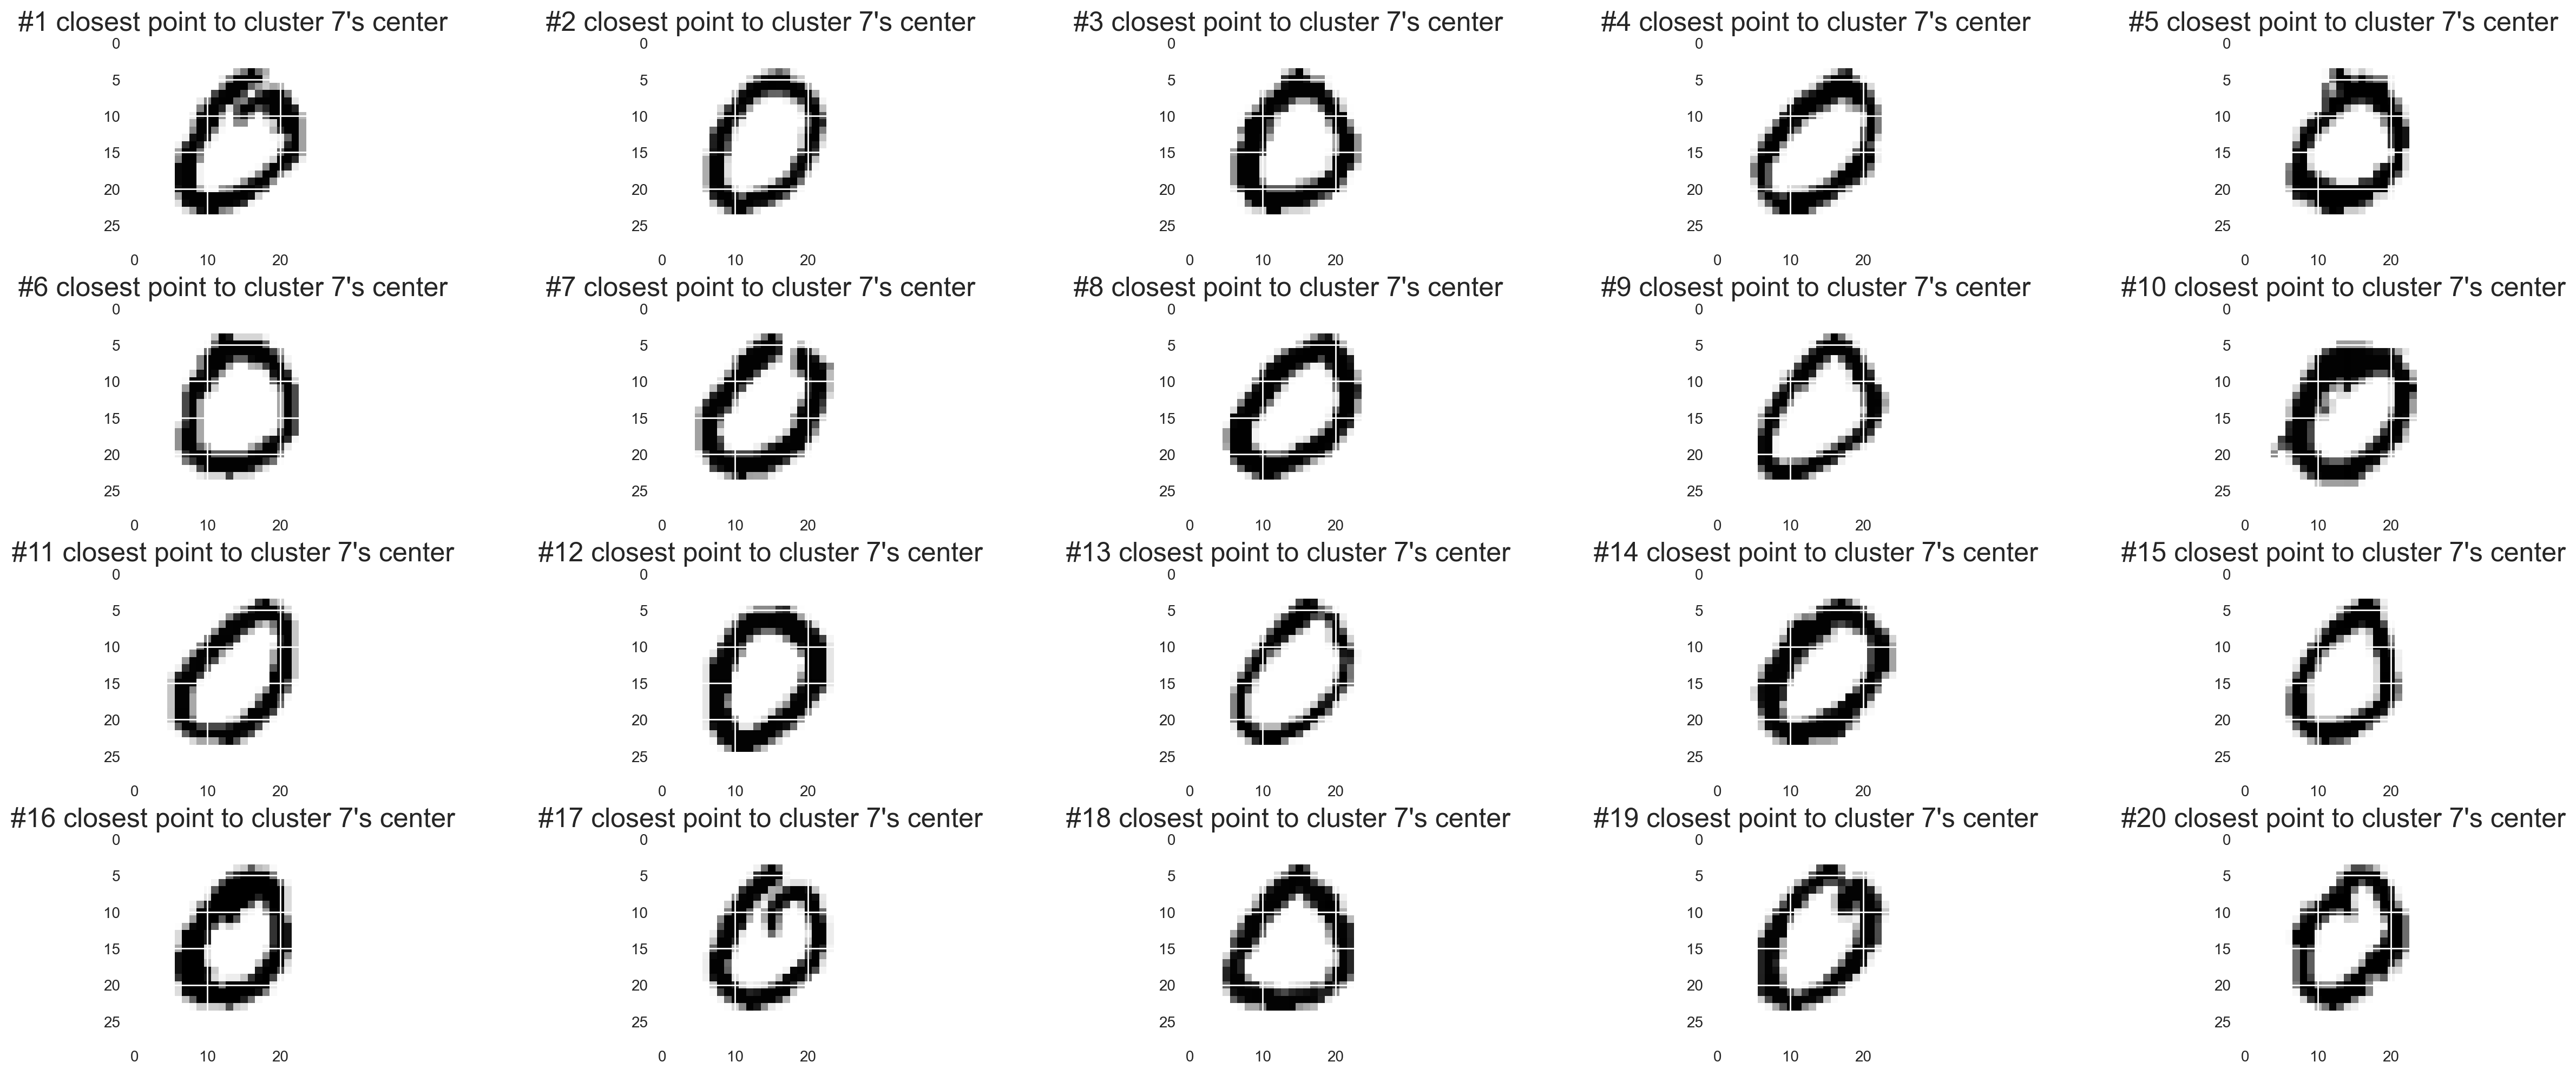

In [15]:
fig, axes = plt.subplots(4, 5, figsize=(30, 12))
axes = axes.flatten()
for idx, (dist, point) in enumerate(zip(distances[sorted_indices], X[sorted_indices])):
    ax = axes[idx]
    ax.imshow(point.reshape(28, 28))
    ax.set_title('#' + str(idx + 1) + " closest point to cluster 7's center", fontsize=18)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # adds some white space between subplots

From the average image of cluster 7 earlier, it's clear that there's a confusion between 7's and 9's. Here's another visualization: we can compute the standard deviation across individual pixels, just for images in cluster 7.

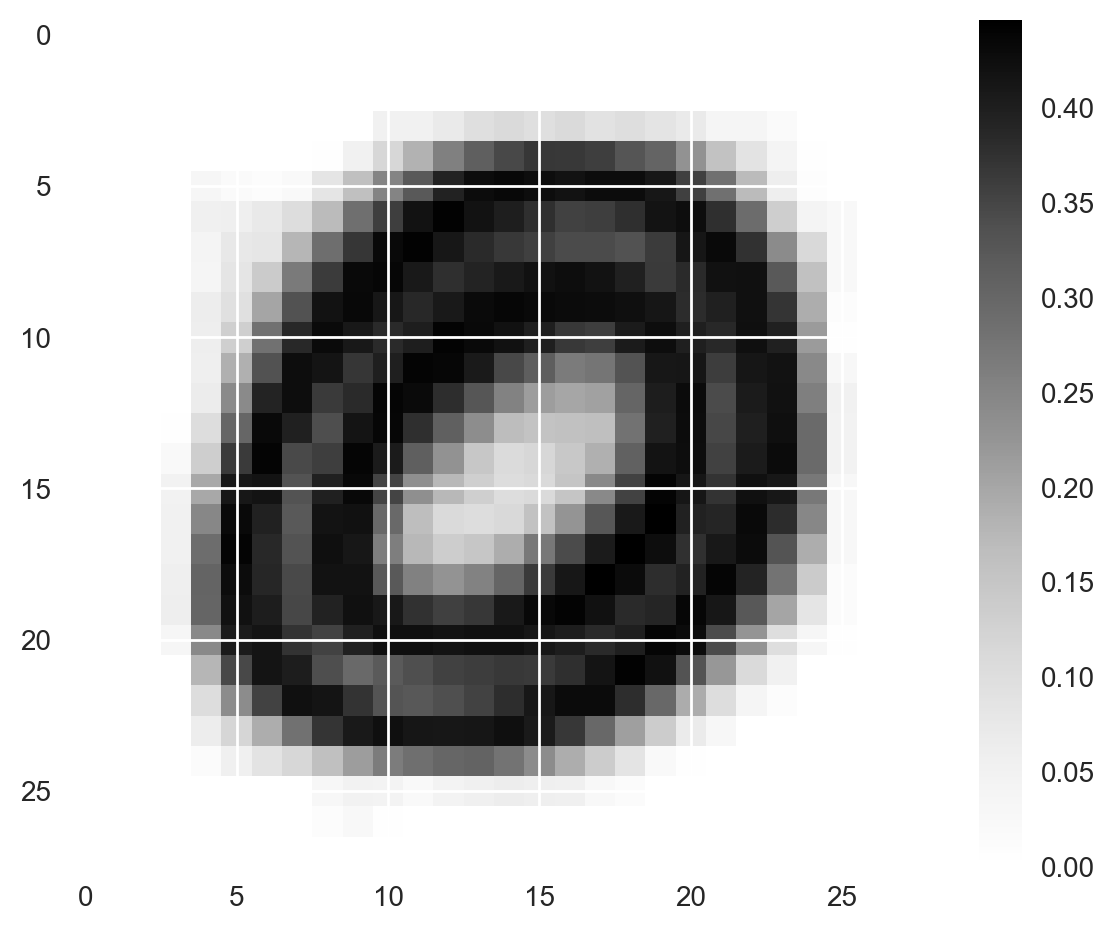

In [16]:
plt.imshow(X[kmeans_cluster_assignments == 7].std(axis=0).reshape(28, 28))
plt.colorbar()

We can see above which pixels appear to have the most variability.

## Clustering in the original space with GMMs

Now, let's try GMM's. We start by clustering in the original space. As a word of caution, this will take some time to run since the original space is quite high-dimensional. We start by importing the GaussianMixture model form sklearn and as before we will call fit and predict to produce our final results.

In [17]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10, n_init=10, random_state=0)
gmm.fit(X)
gmm_cluster_assignments = gmm.predict(X)

Just as with k-means, we can visualize cluster means:

In [18]:
print(gmm.means_)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Here, we plot the learned cluster means (the $\mu_i$'s) and also standard deviations per pixel (technical detail: these come from taking the diagonal entries of the covariance matrices $\Sigma_i$'s and then taking square root since the diagonal entries actually store variances and not standard deviations).

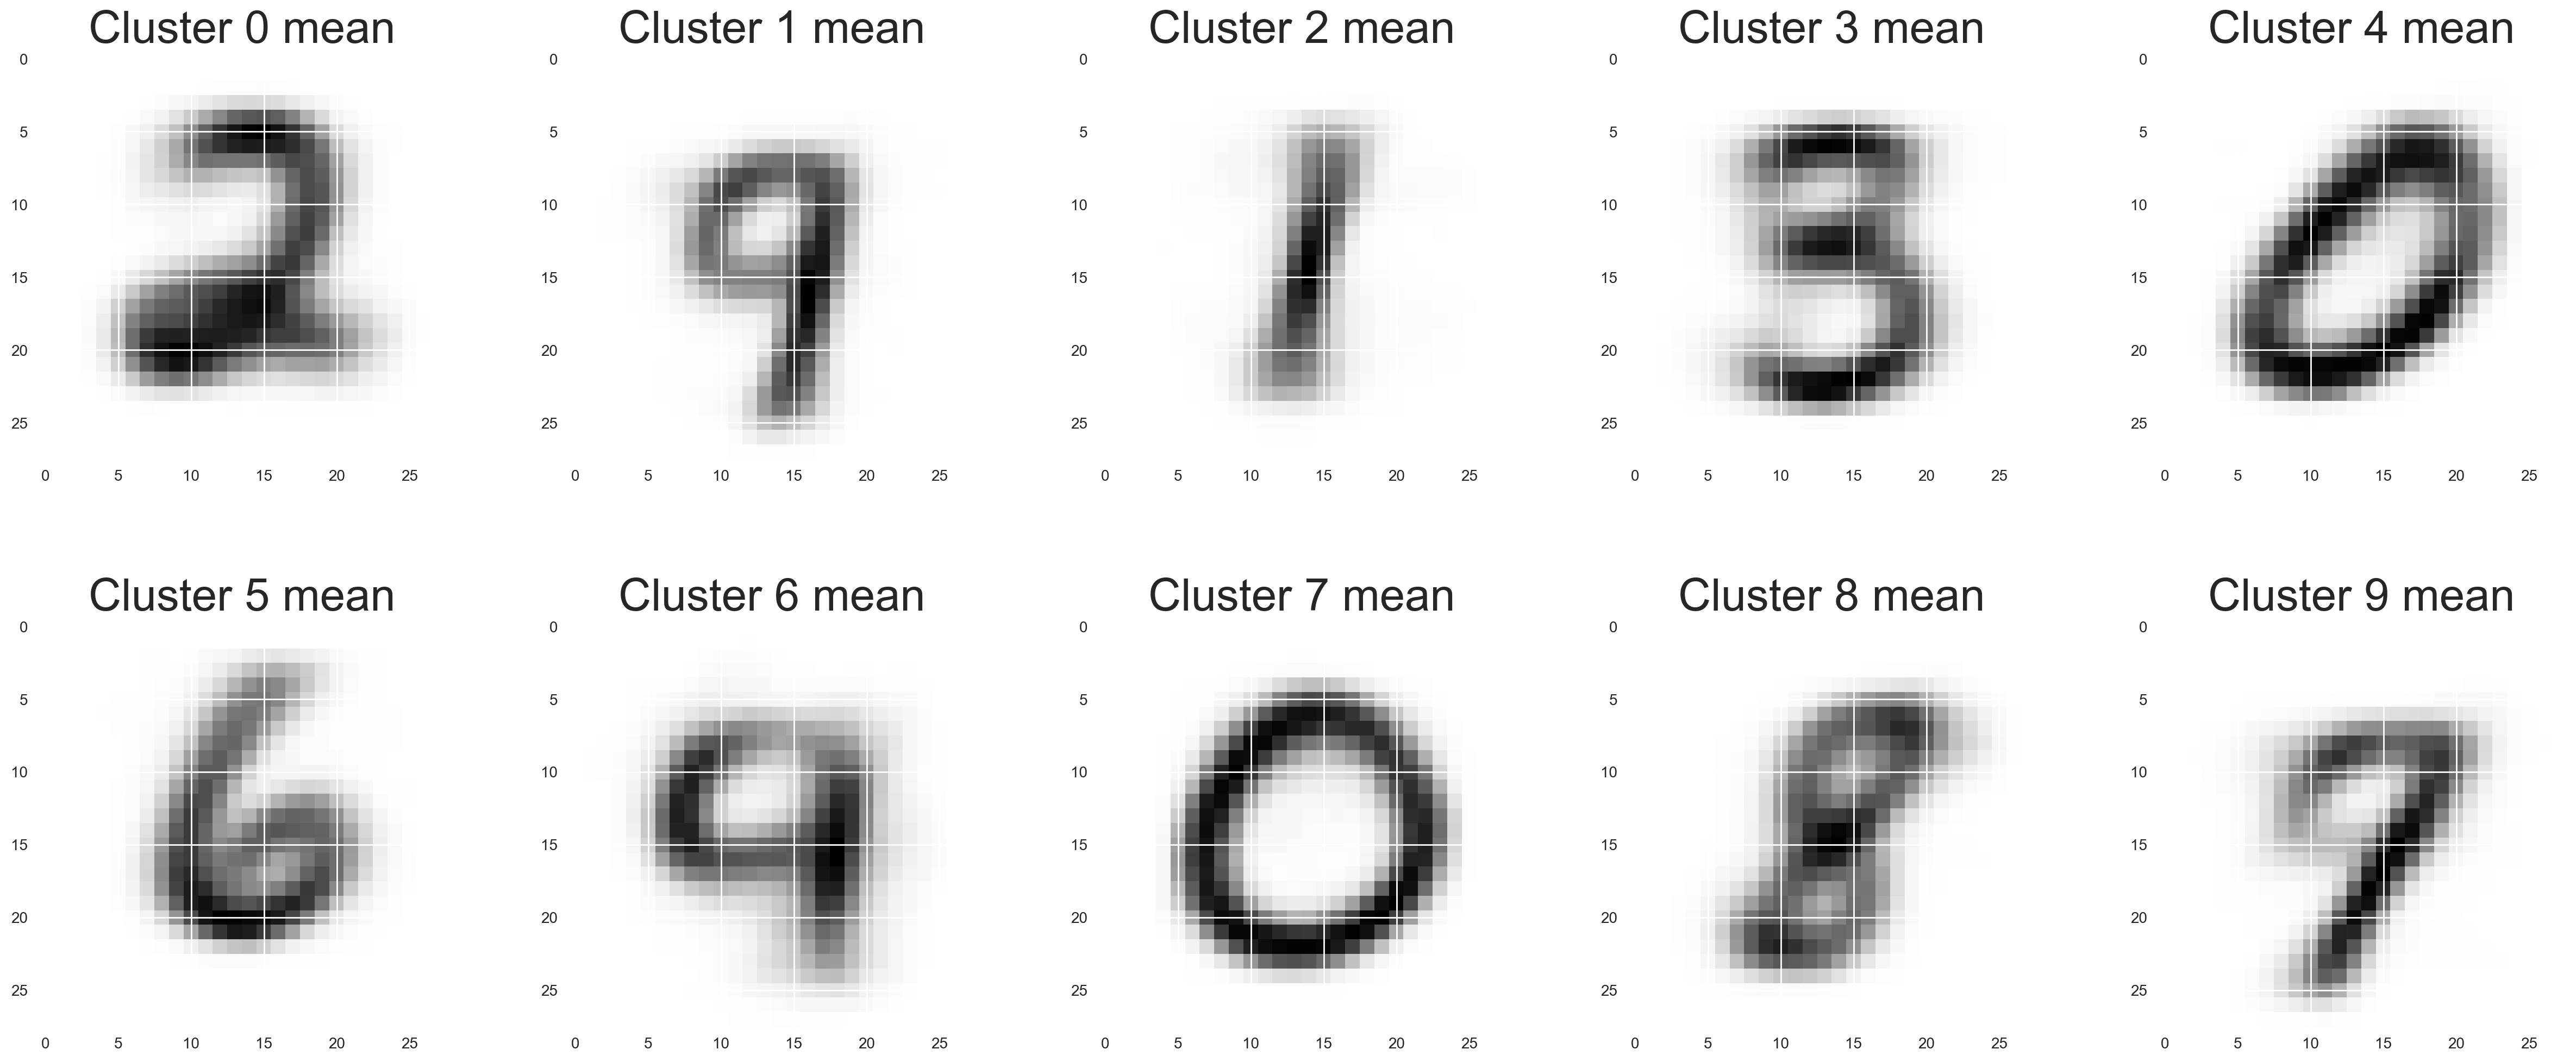

In [19]:
fig, axes = plt.subplots(2, 5, figsize=(30, 12))
axes = axes.flatten()
for cluster_idx in range(10):
    ax = axes[cluster_idx]
    ax.imshow(gmm.means_[cluster_idx].reshape(28, 28))
    ax.set_title('Cluster ' + str(cluster_idx) + ' mean', fontsize=30)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # adds some white space between subplots

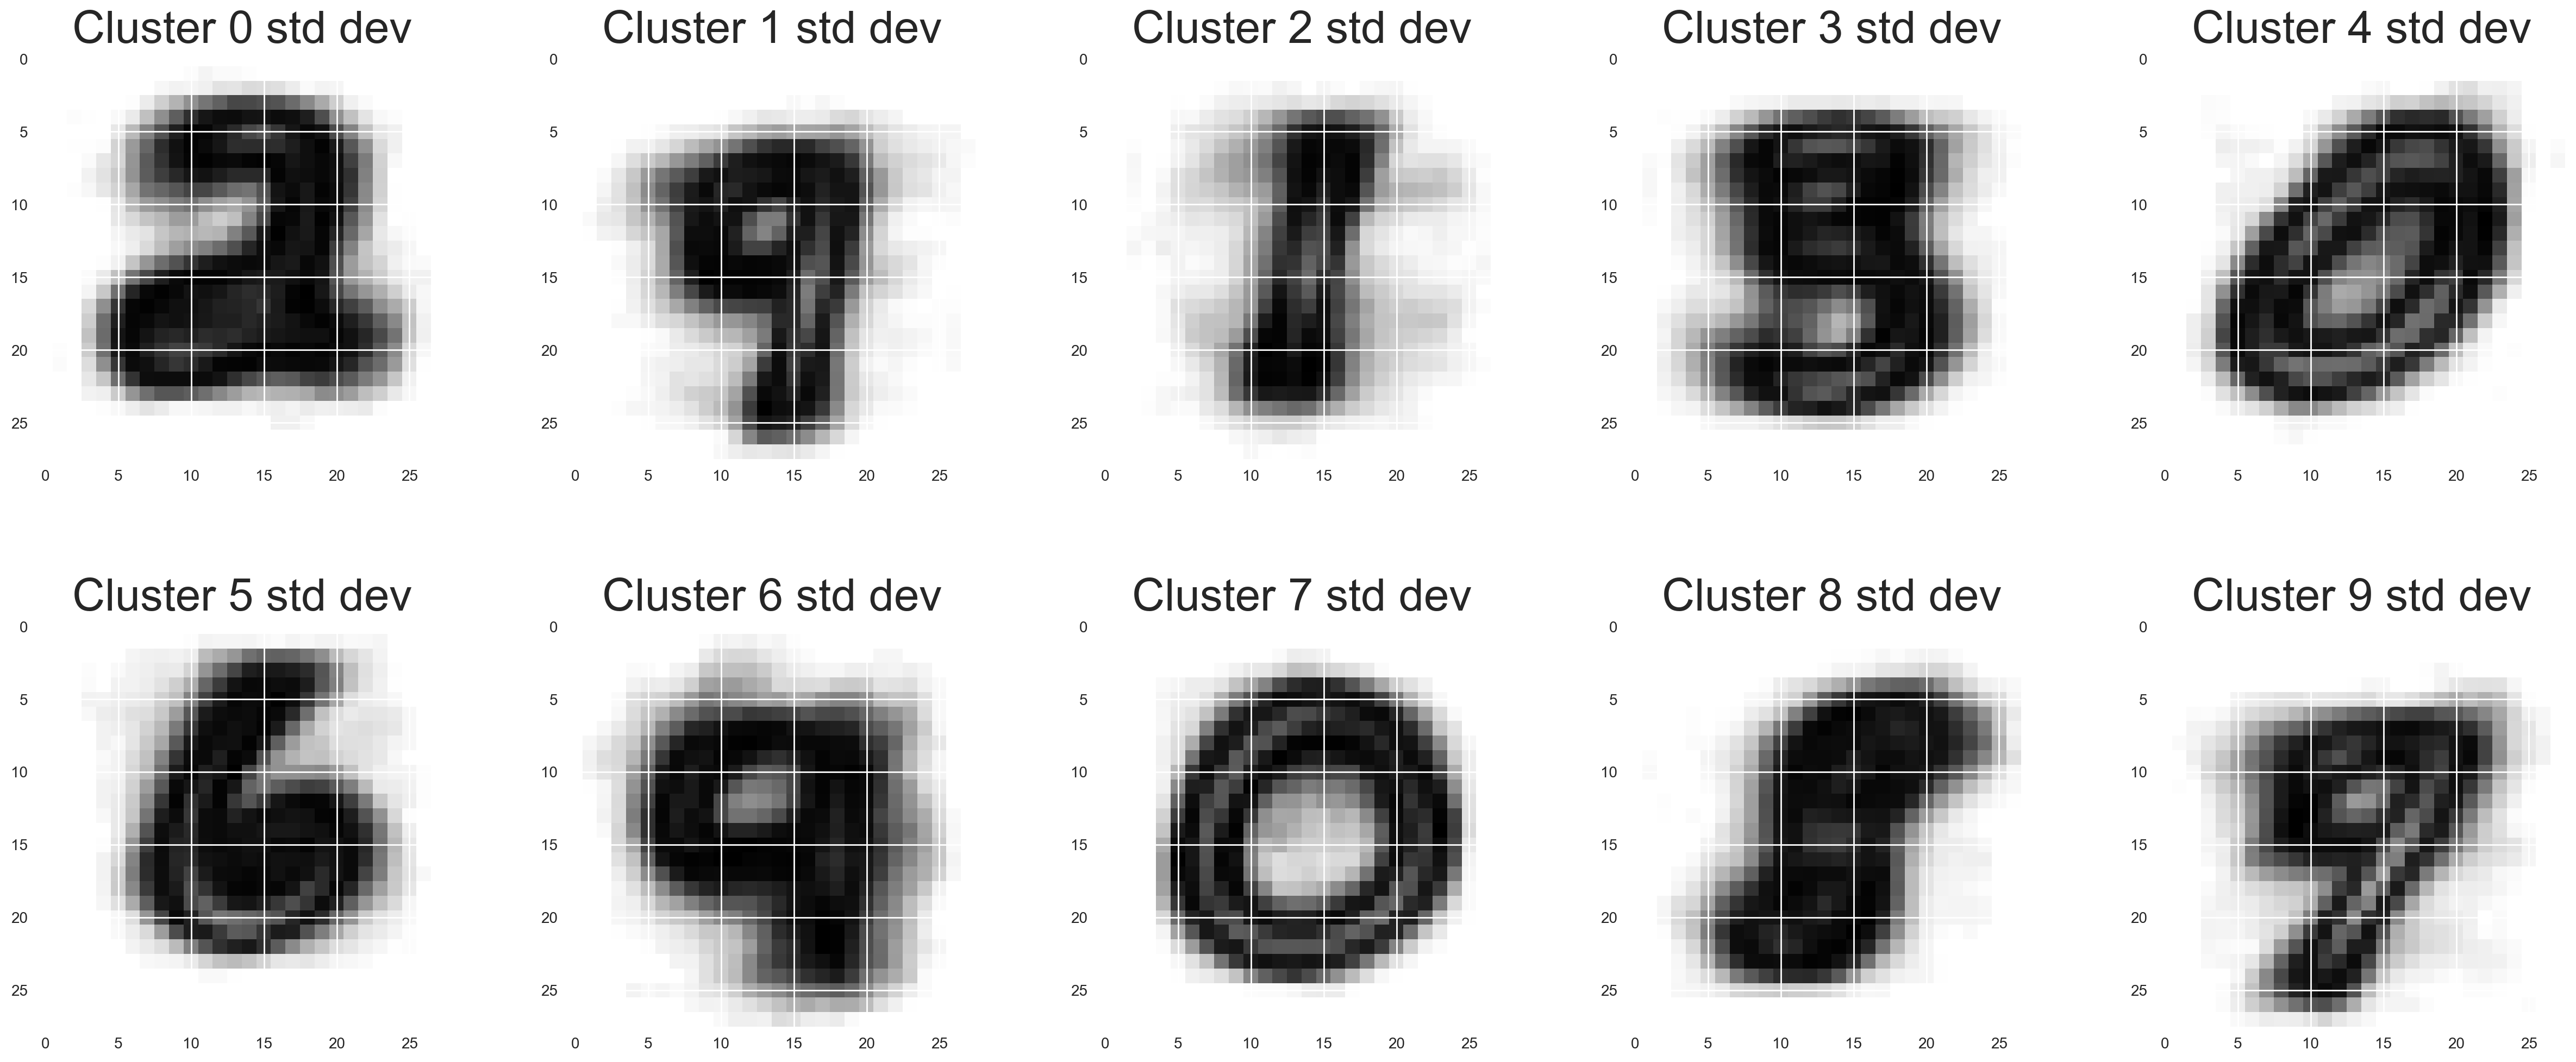

In [20]:
fig, axes = plt.subplots(2, 5, figsize=(30, 12))
axes = axes.flatten()
for cluster_idx in range(10):
    ax = axes[cluster_idx]
    ax.imshow(np.sqrt(np.diag(gmm.covariances_[cluster_idx])).reshape(28, 28))
    ax.set_title('Cluster ' + str(cluster_idx) + ' std dev', fontsize=30)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # adds some white space between subplots

Just as with k-means, we can also find which of the images in the dataset are closest to a cluster center, but now we should account for shape and not use raw Euclidean distances! How do we do this? The important basic idea here is that we work with probabilities. The probabilities serve as the similarity scores!

In [21]:
prob_being_in_different_clusters = gmm.predict_proba(X)

In [22]:
prob_being_in_different_clusters[492]

array([0.00000000e+000, 0.00000000e+000, 1.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       3.42489161e-283, 0.00000000e+000])

Finally, for instance, we can look at the top 20 points (rows/digits) with the highest probability of belonging to cluster 0

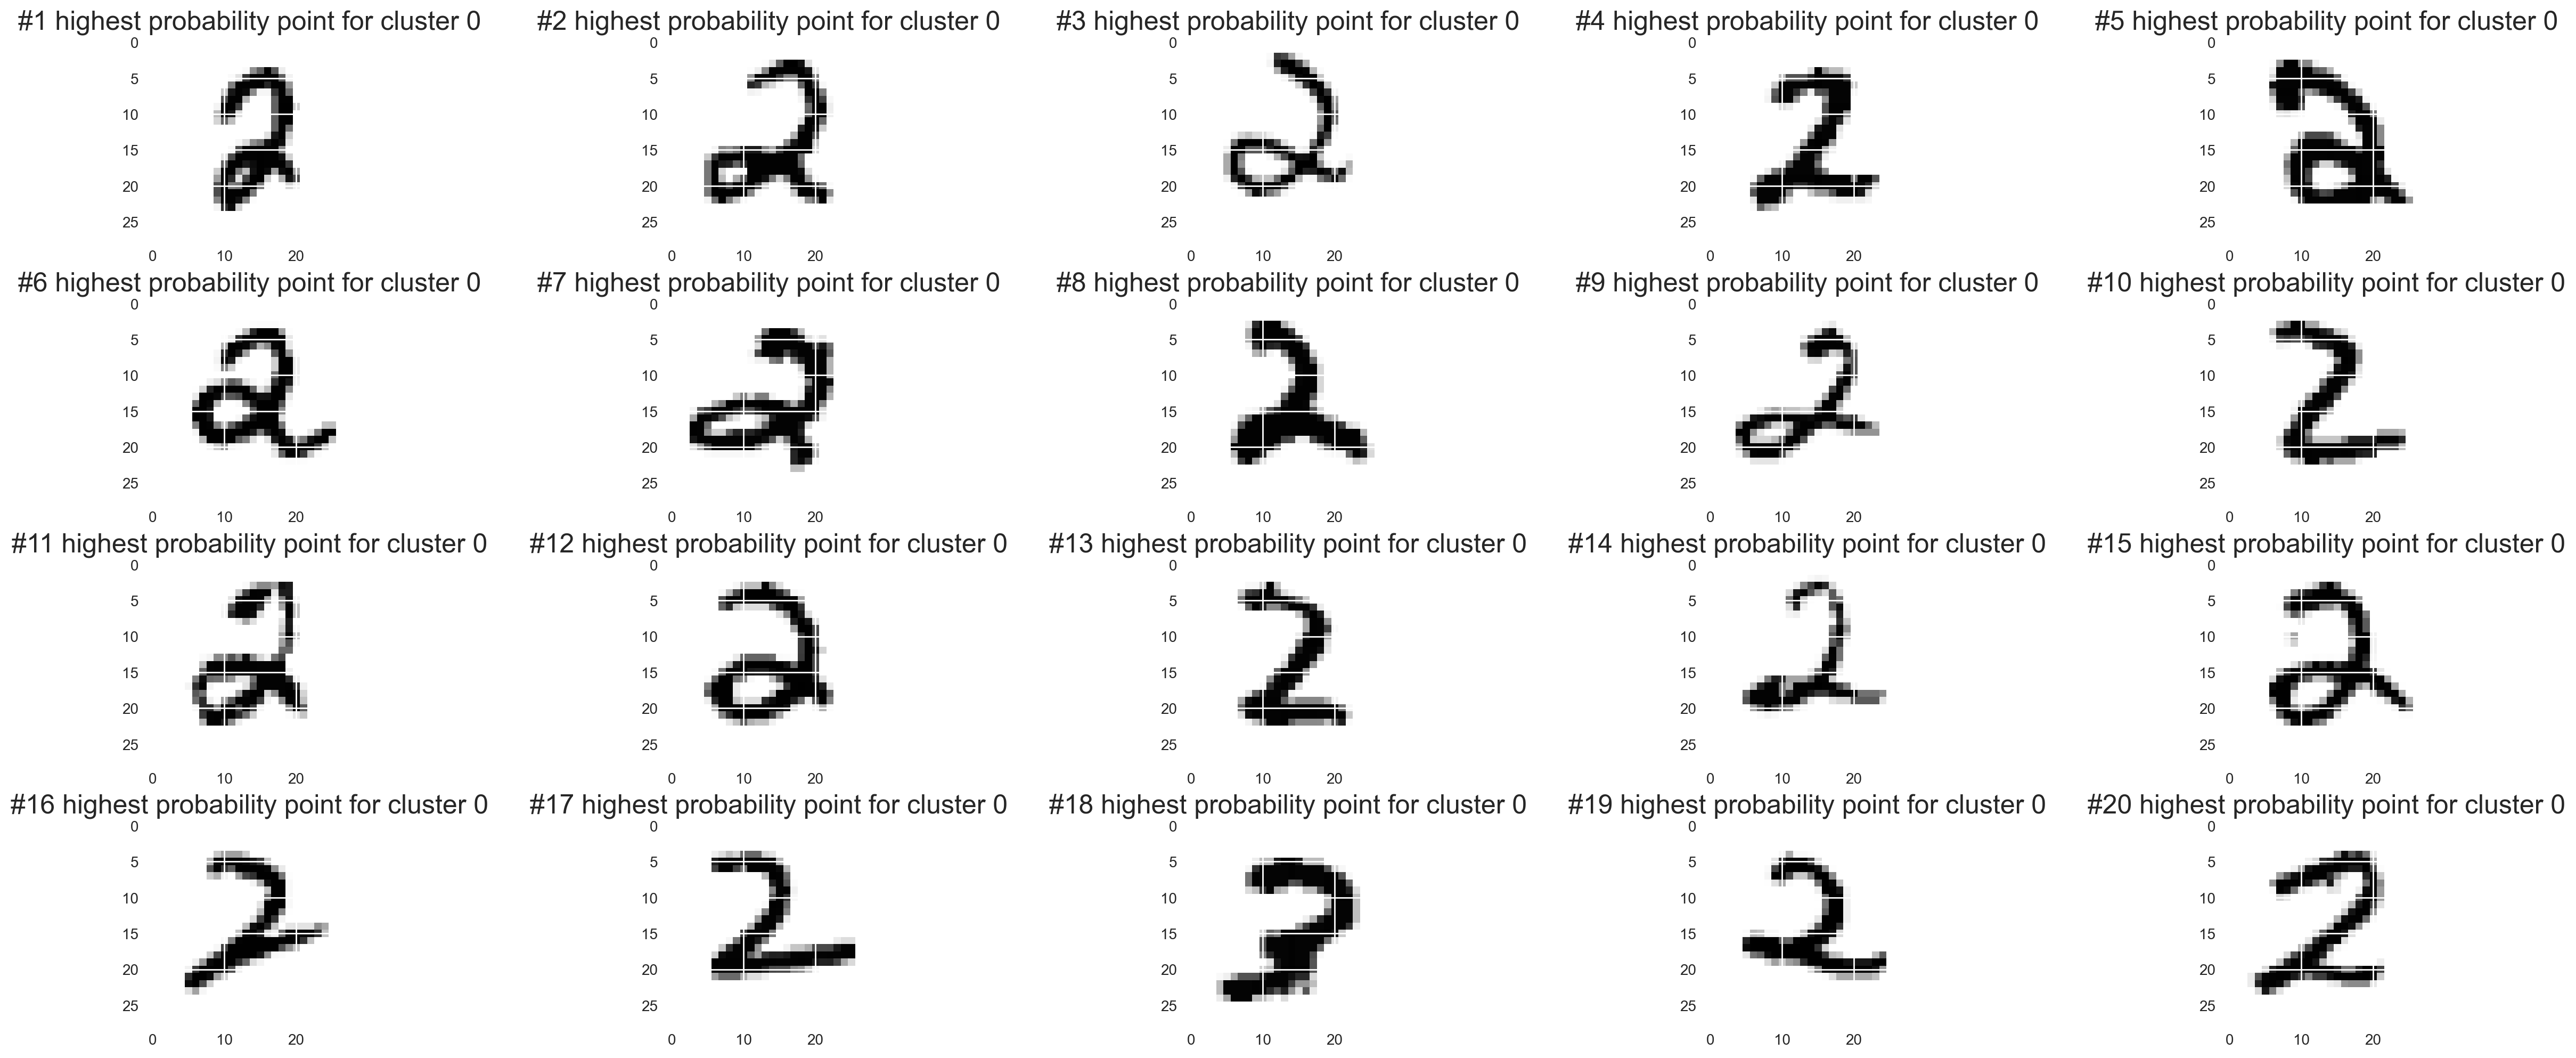

In [23]:
sorted_indices = np.argsort(-prob_being_in_different_clusters[:, 0])[:20]

fig, axes = plt.subplots(4, 5, figsize=(30, 12))
axes = axes.flatten()
for idx, (dist, point) in enumerate(zip(distances[sorted_indices], X[sorted_indices])):
    ax = axes[idx]
    ax.imshow(point.reshape(28, 28))
    ax.set_title('#' + str(idx + 1) + " highest probability point for cluster 0", fontsize=18)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # adds some white space between subplots

## Clustering in a 2D t-SNE space with k-means

We can repeat what we did above but now apply clustering in a 2D t-SNE space. A few reminders:

- By clustering in a 2D t-SNE space, we are using a representation of the data that has lost information (t-SNE reduces 784 dimensions down to 2 and does not retain all the information in that original 784-dimensional space).
- t-SNE has a bunch of parameters that we have to set such as the perplexity, the learning rate, and the number of iterations/steps to optimize (there are actually more parameters); by choosing these parameters differently, we will get different 2D t-SNE representations! We show how to cluster the 2D t-SNE representation of just one way to set all these parameters.

In [24]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000, random_state=0)
feature_vectors_tsne2d = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 1.505s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.321663
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.635078
[t-SNE] KL divergence after 1000 iterations: 1.489961


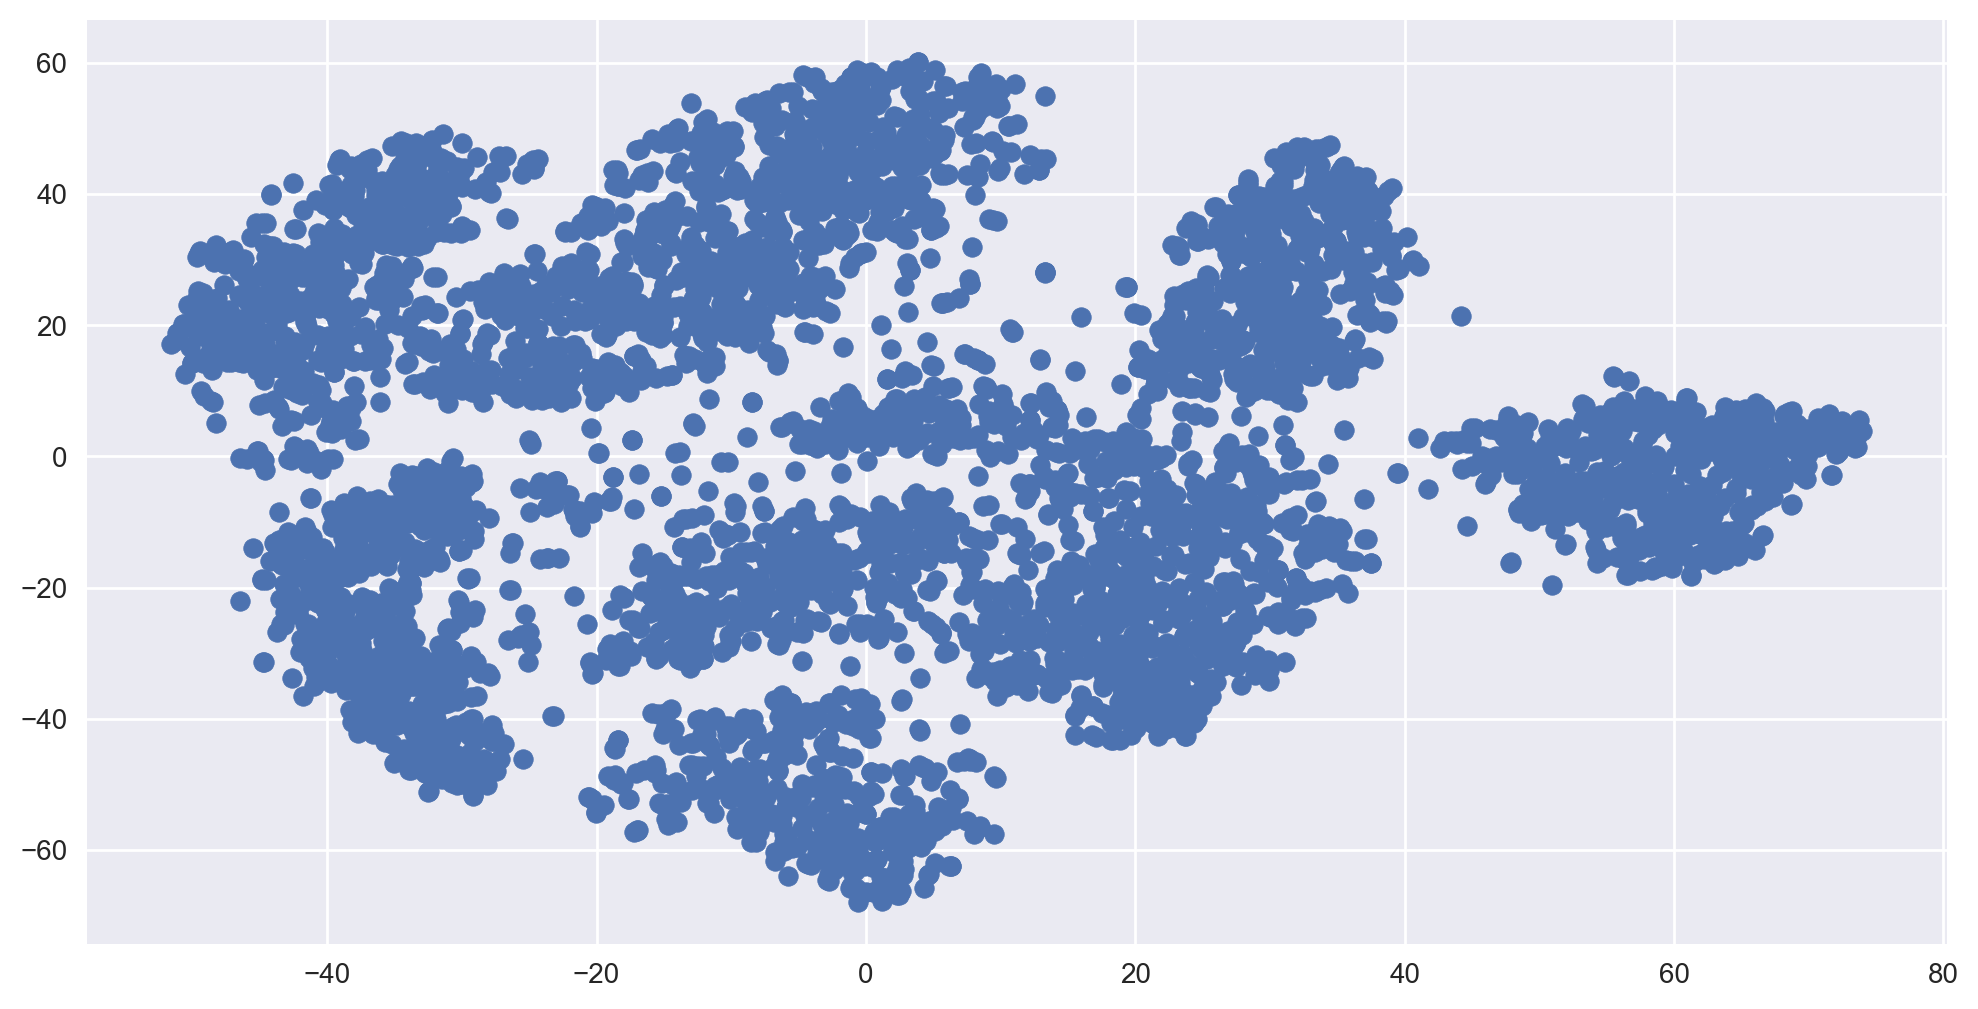

In [25]:
plt.figure(figsize=(12, 6))
plt.scatter(feature_vectors_tsne2d[:, 0], feature_vectors_tsne2d[:, 1])

Recall that we can color the points based on cluster the true digit labels (that t-SNE doesn't actually know).

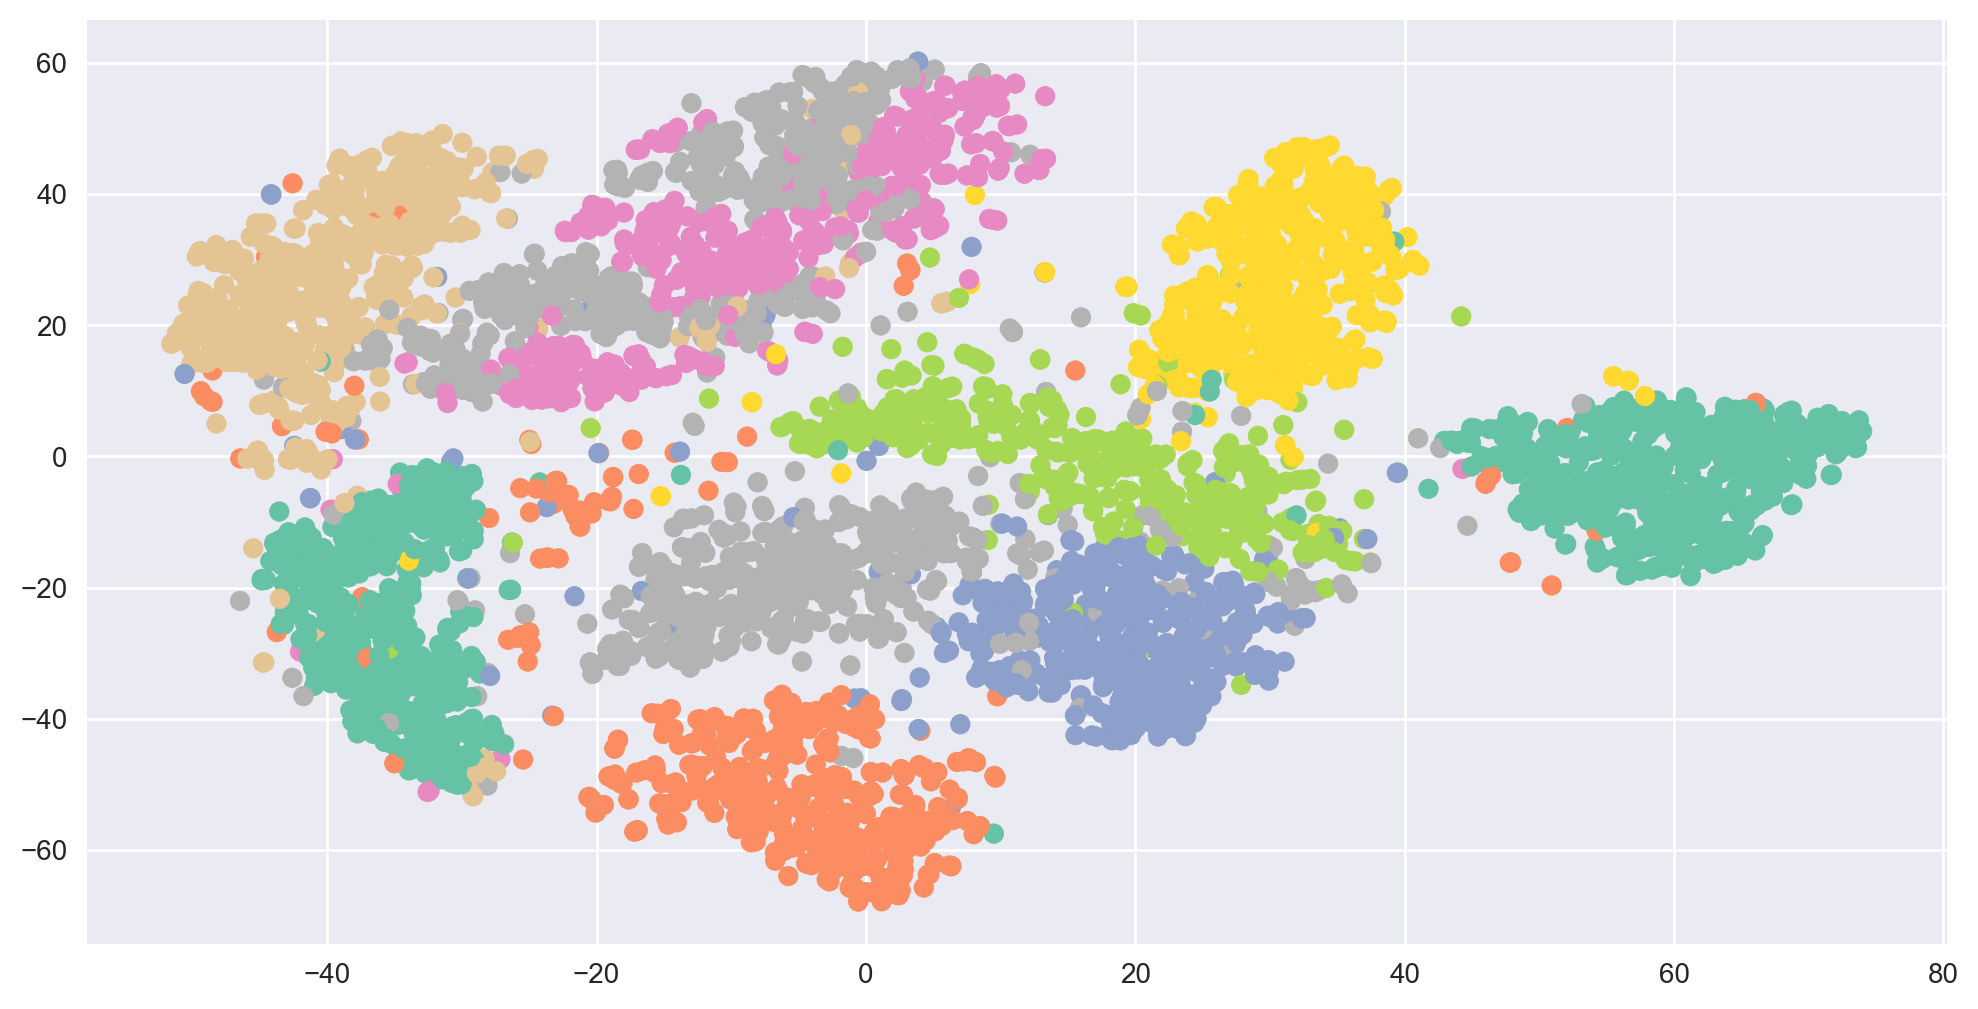

In [26]:
plt.figure(figsize=(12, 6))
plt.scatter(feature_vectors_tsne2d[:, 0], feature_vectors_tsne2d[:, 1],
            c=labels[random_sample], cmap='Set2')

It appears that some digits are getting confused with each other.

We now run k-means on the 2D t-SNE vectors.

In [27]:
new_kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)
new_kmeans.fit(feature_vectors_tsne2d)

KMeans(n_clusters=10, n_init=10, random_state=0)

Unlike when we worked in the original space, the cluster means in 2D are now just 2D points. **In particular, the cluster means in 2D t-SNE space are no longer images that we can readily visualize, but just pairs of numbers.**

In [28]:
new_kmeans.cluster_centers_

array([[ -6.4468403, -18.889866 ],
       [ -4.2284164, -51.65765  ],
       [ 12.505167 ,   2.061888 ],
       [ -4.460226 ,  40.276928 ],
       [-35.02025  , -10.2220745],
       [-33.219135 ,  24.255676 ],
       [ 30.80284  ,  27.156748 ],
       [ 21.322351 , -24.781204 ],
       [-33.533924 , -35.70182  ],
       [ 58.904167 ,  -2.776155 ]], dtype=float32)

Let's look at how well the cluster assignment found by k-means compares to the ground truth digit labels.

In [29]:
new_kmeans_cluster_assignments = new_kmeans.predict(feature_vectors_tsne2d)

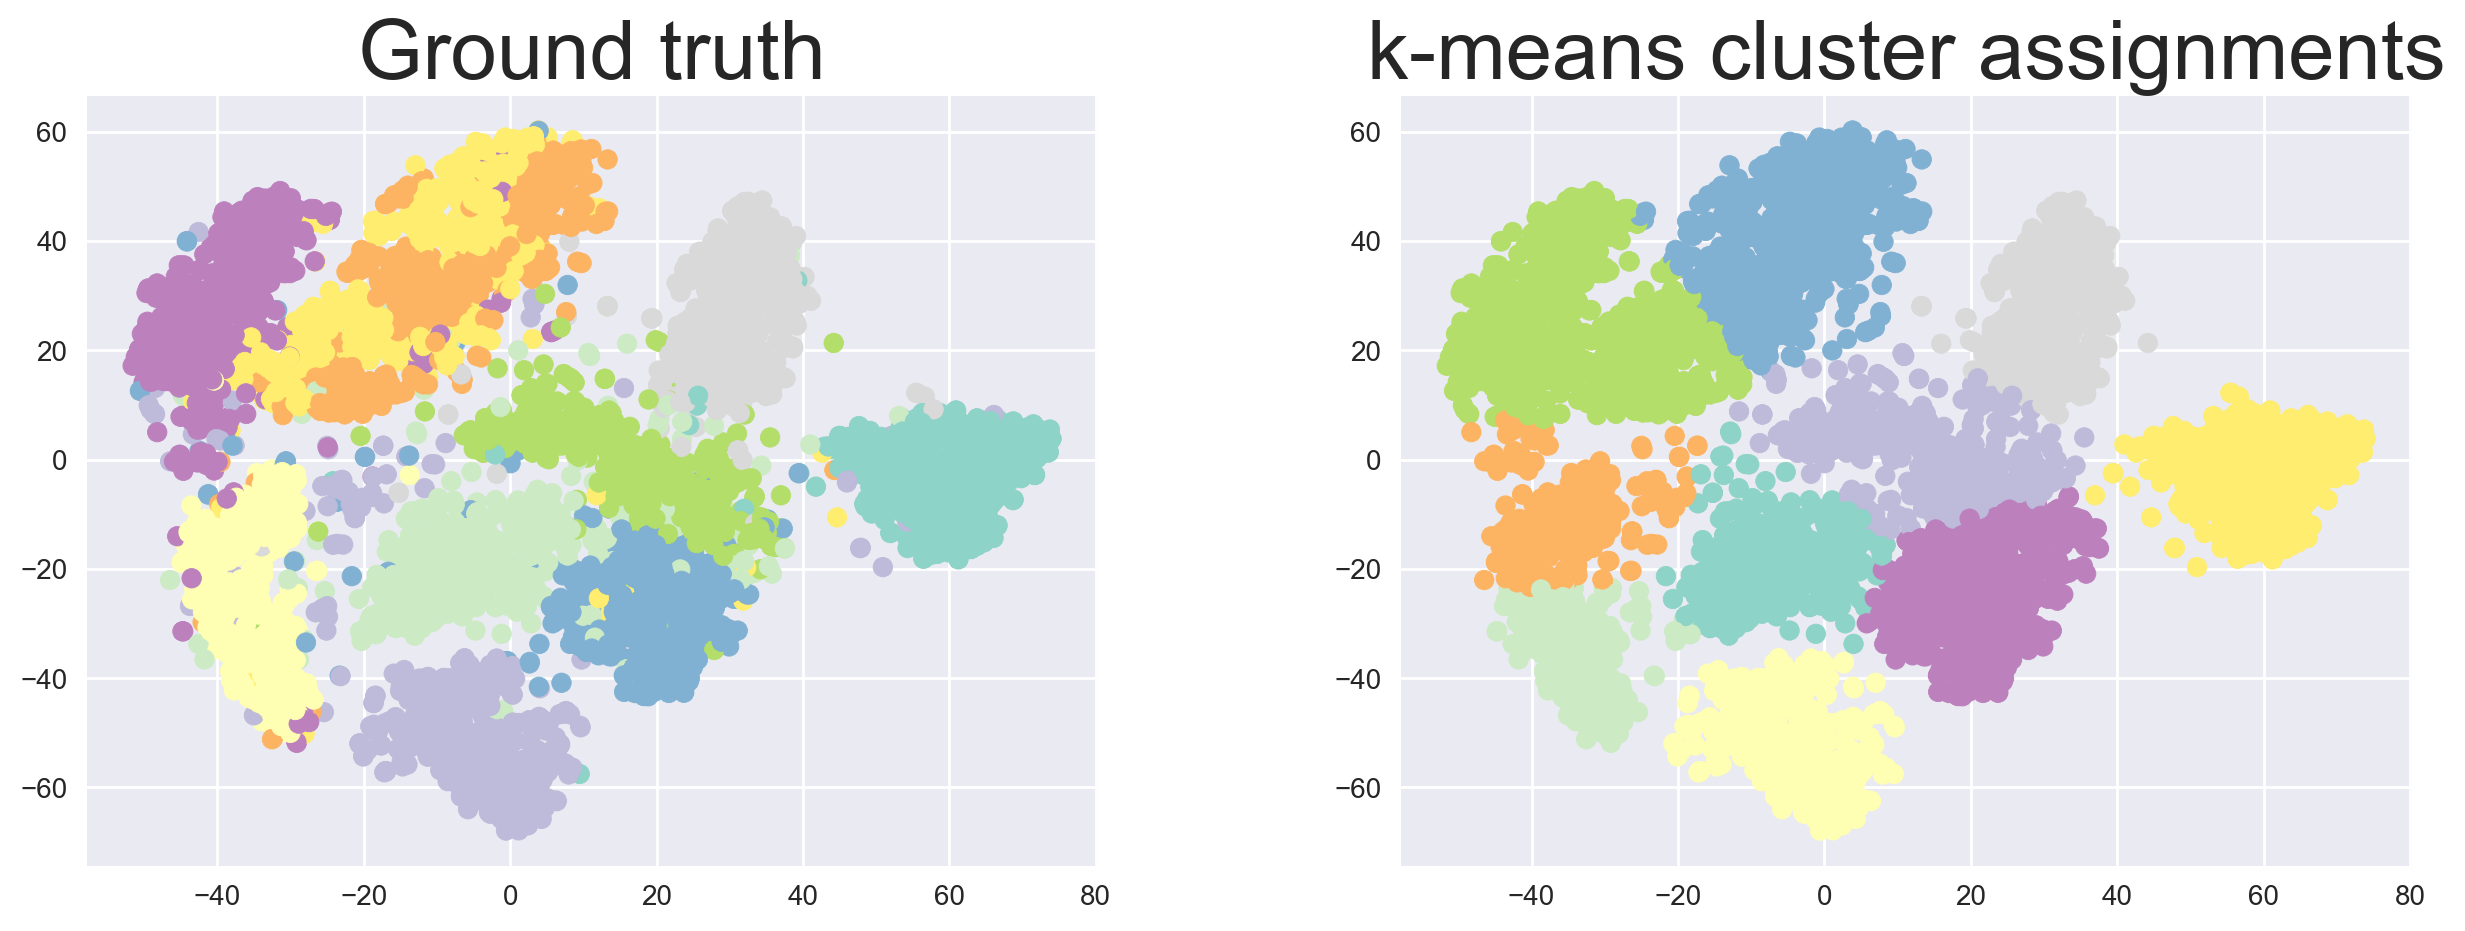

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten() 
axes[0].scatter(feature_vectors_tsne2d[:, 0], feature_vectors_tsne2d[:, 1],
                c=labels[random_sample], cmap='Set3')
axes[0].set_title('Ground truth', fontsize=30)
axes[1].scatter(feature_vectors_tsne2d[:, 0], feature_vectors_tsne2d[:, 1],
                c=new_kmeans_cluster_assignments, cmap='Set3')
axes[1].set_title('k-means cluster assignments', fontsize=30)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # adds some white space between subplots

Similar to what we did in lecture with t-SNE and the drug consumption data, the idea is to visualize things in the original space, but use cluster assignments from the 2D t-SNE space we found.

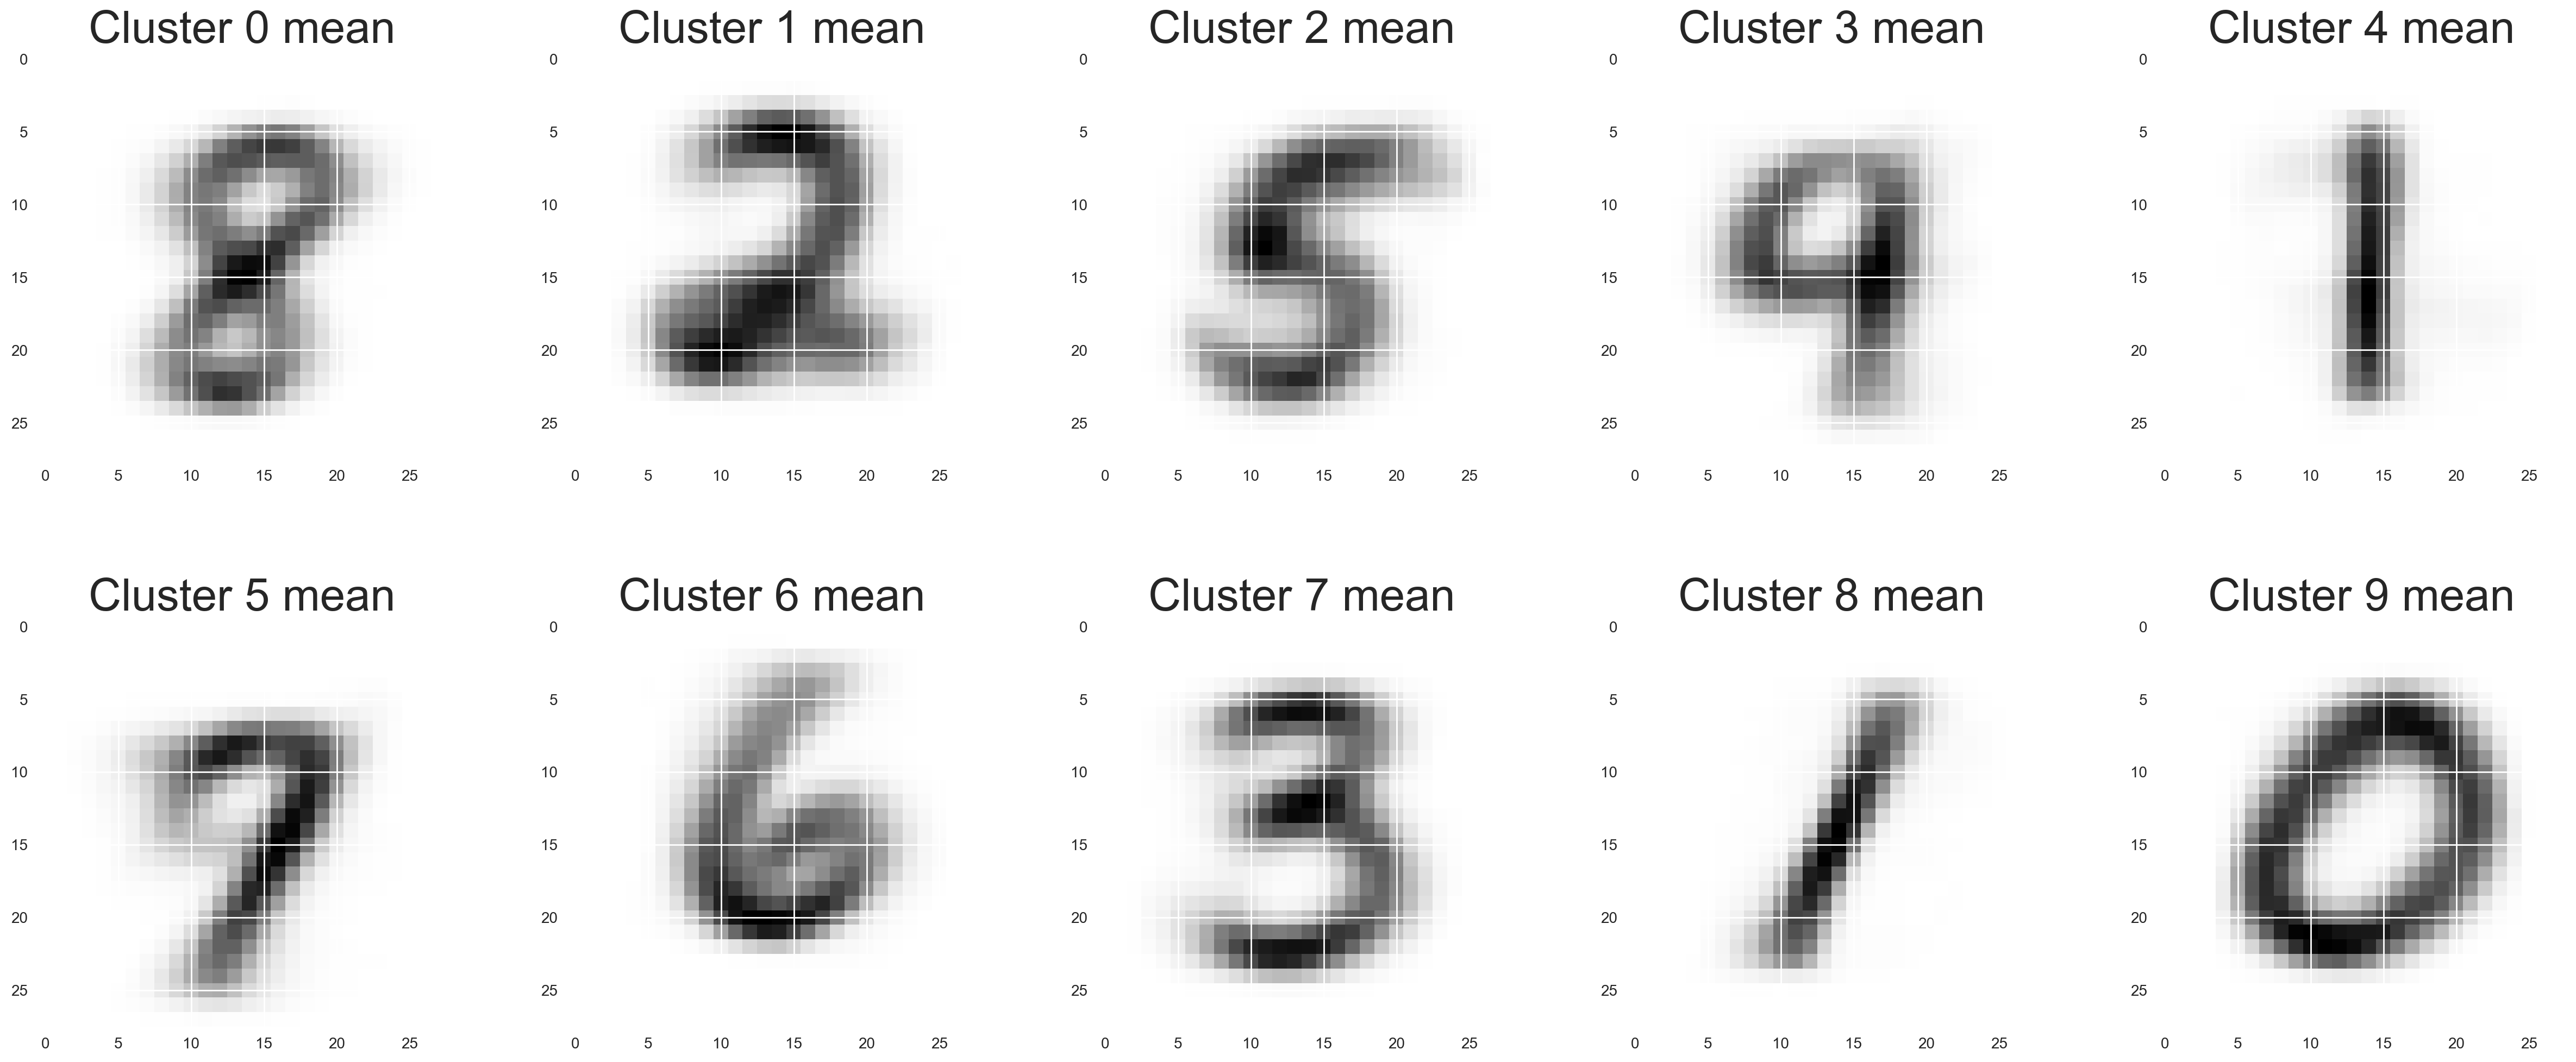

In [31]:
fig, axes = plt.subplots(2, 5, figsize=(30, 12))
axes = axes.flatten()

for cluster_idx in range(10):
    ax = axes[cluster_idx]
    ax.imshow(X[new_kmeans_cluster_assignments == cluster_idx].mean(axis=0).reshape(28, 28))
    ax.set_title('Cluster ' + str(cluster_idx) + ' mean', fontsize=30)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # adds some white space between subplots

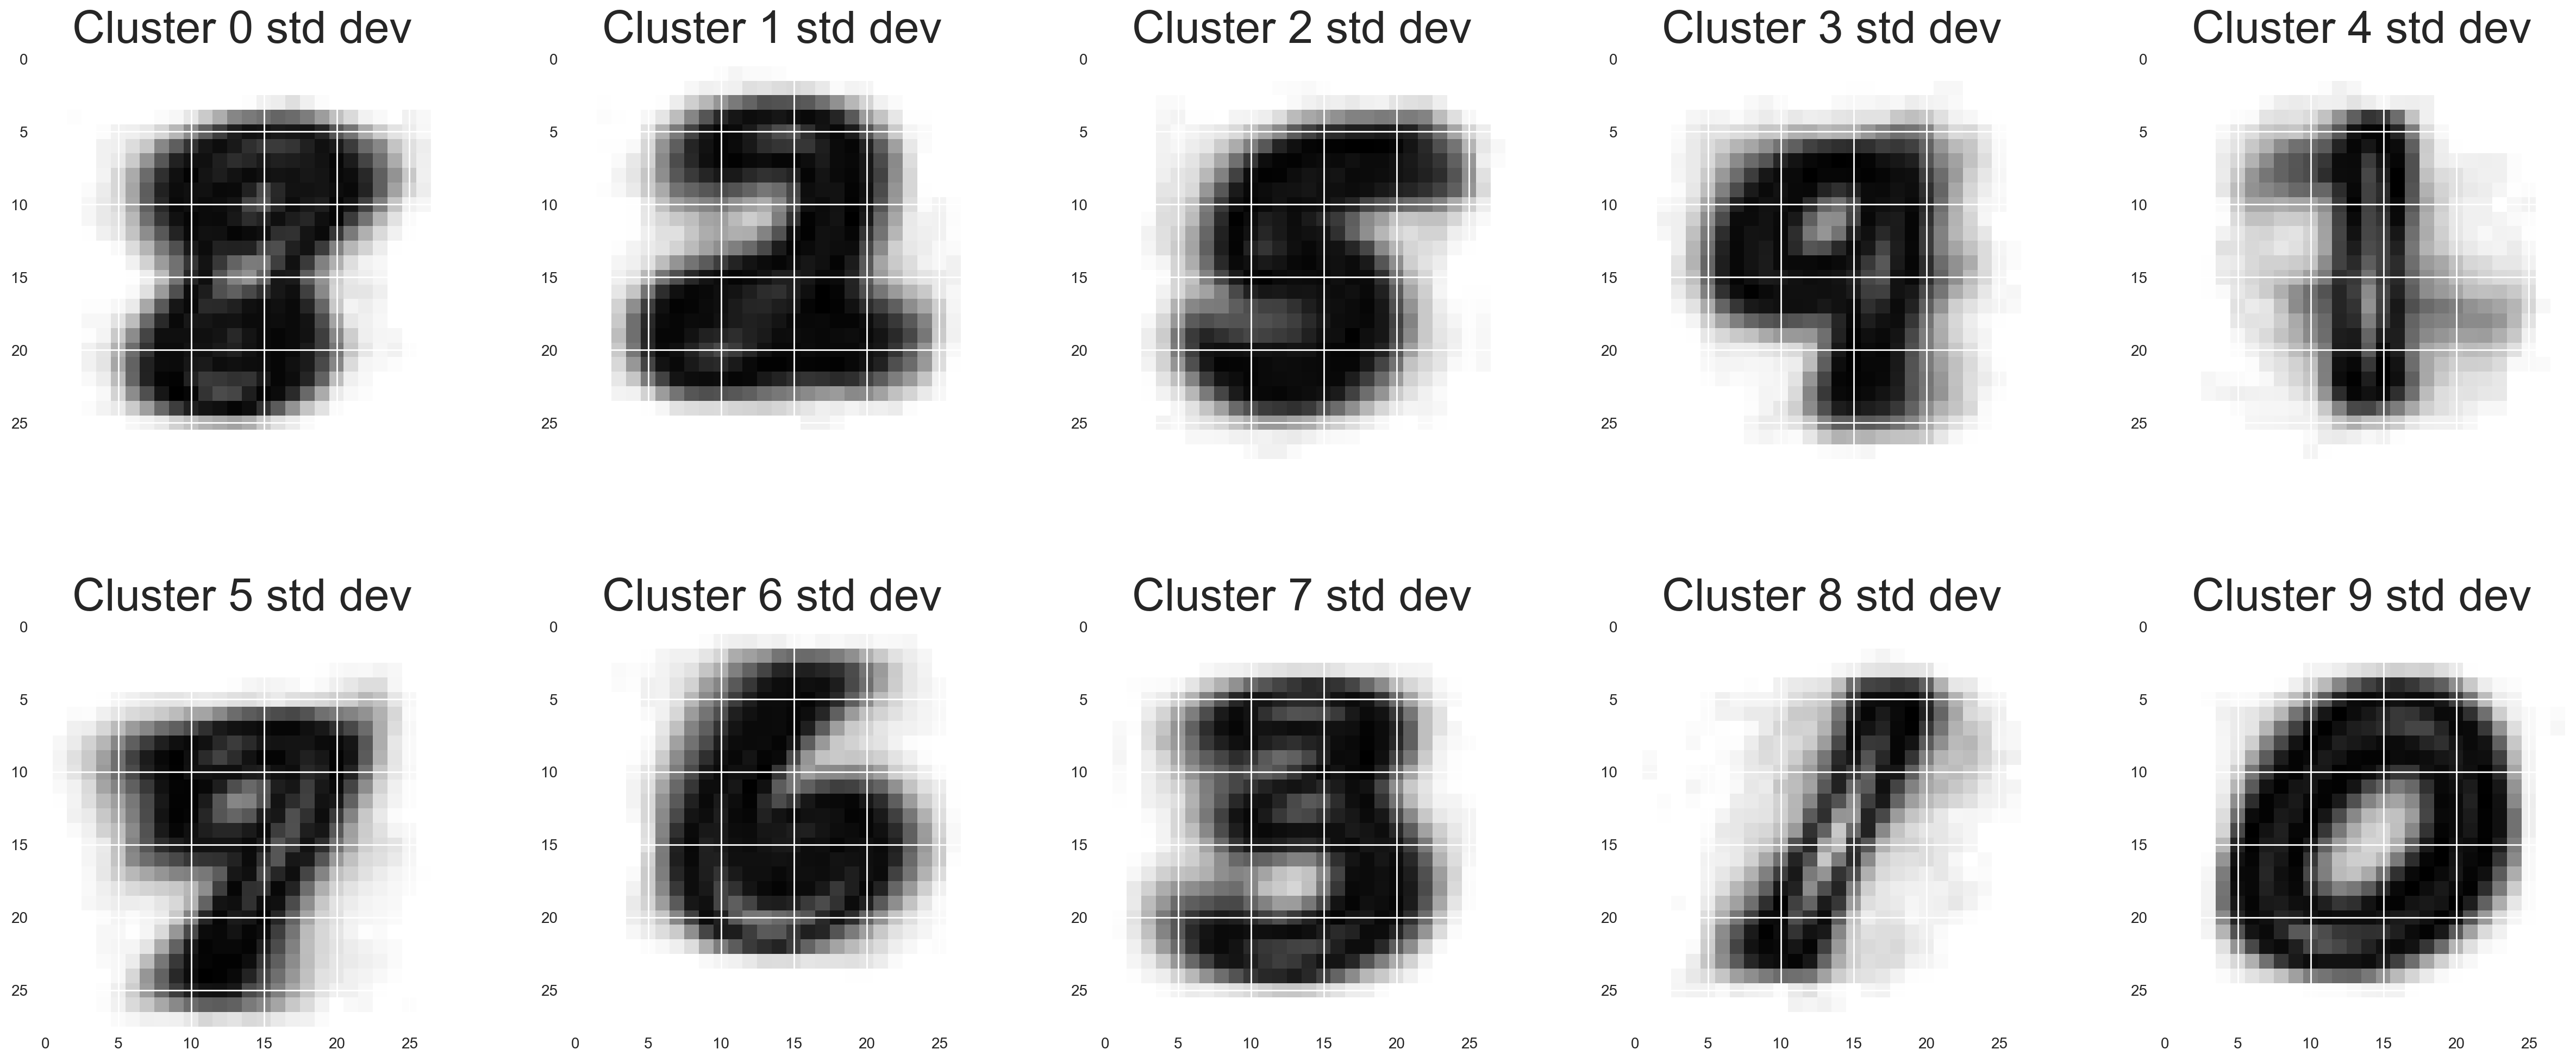

In [32]:
fig, axes = plt.subplots(2, 5, figsize=(30, 12), sharex=True)
axes = axes.flatten()

for cluster_idx in range(10):
    ax = axes[cluster_idx]
    ax.imshow(X[new_kmeans_cluster_assignments == cluster_idx].std(axis=0).reshape(28, 28))
    ax.set_title('Cluster ' + str(cluster_idx) + ' std dev', fontsize=30)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # adds some white space between subplots

We can again figure out what images are considered closest to a particular cluster (such as cluster 3) but this time using distances in the 2D t-SNE space (and *not* the original 784-dimensional space).

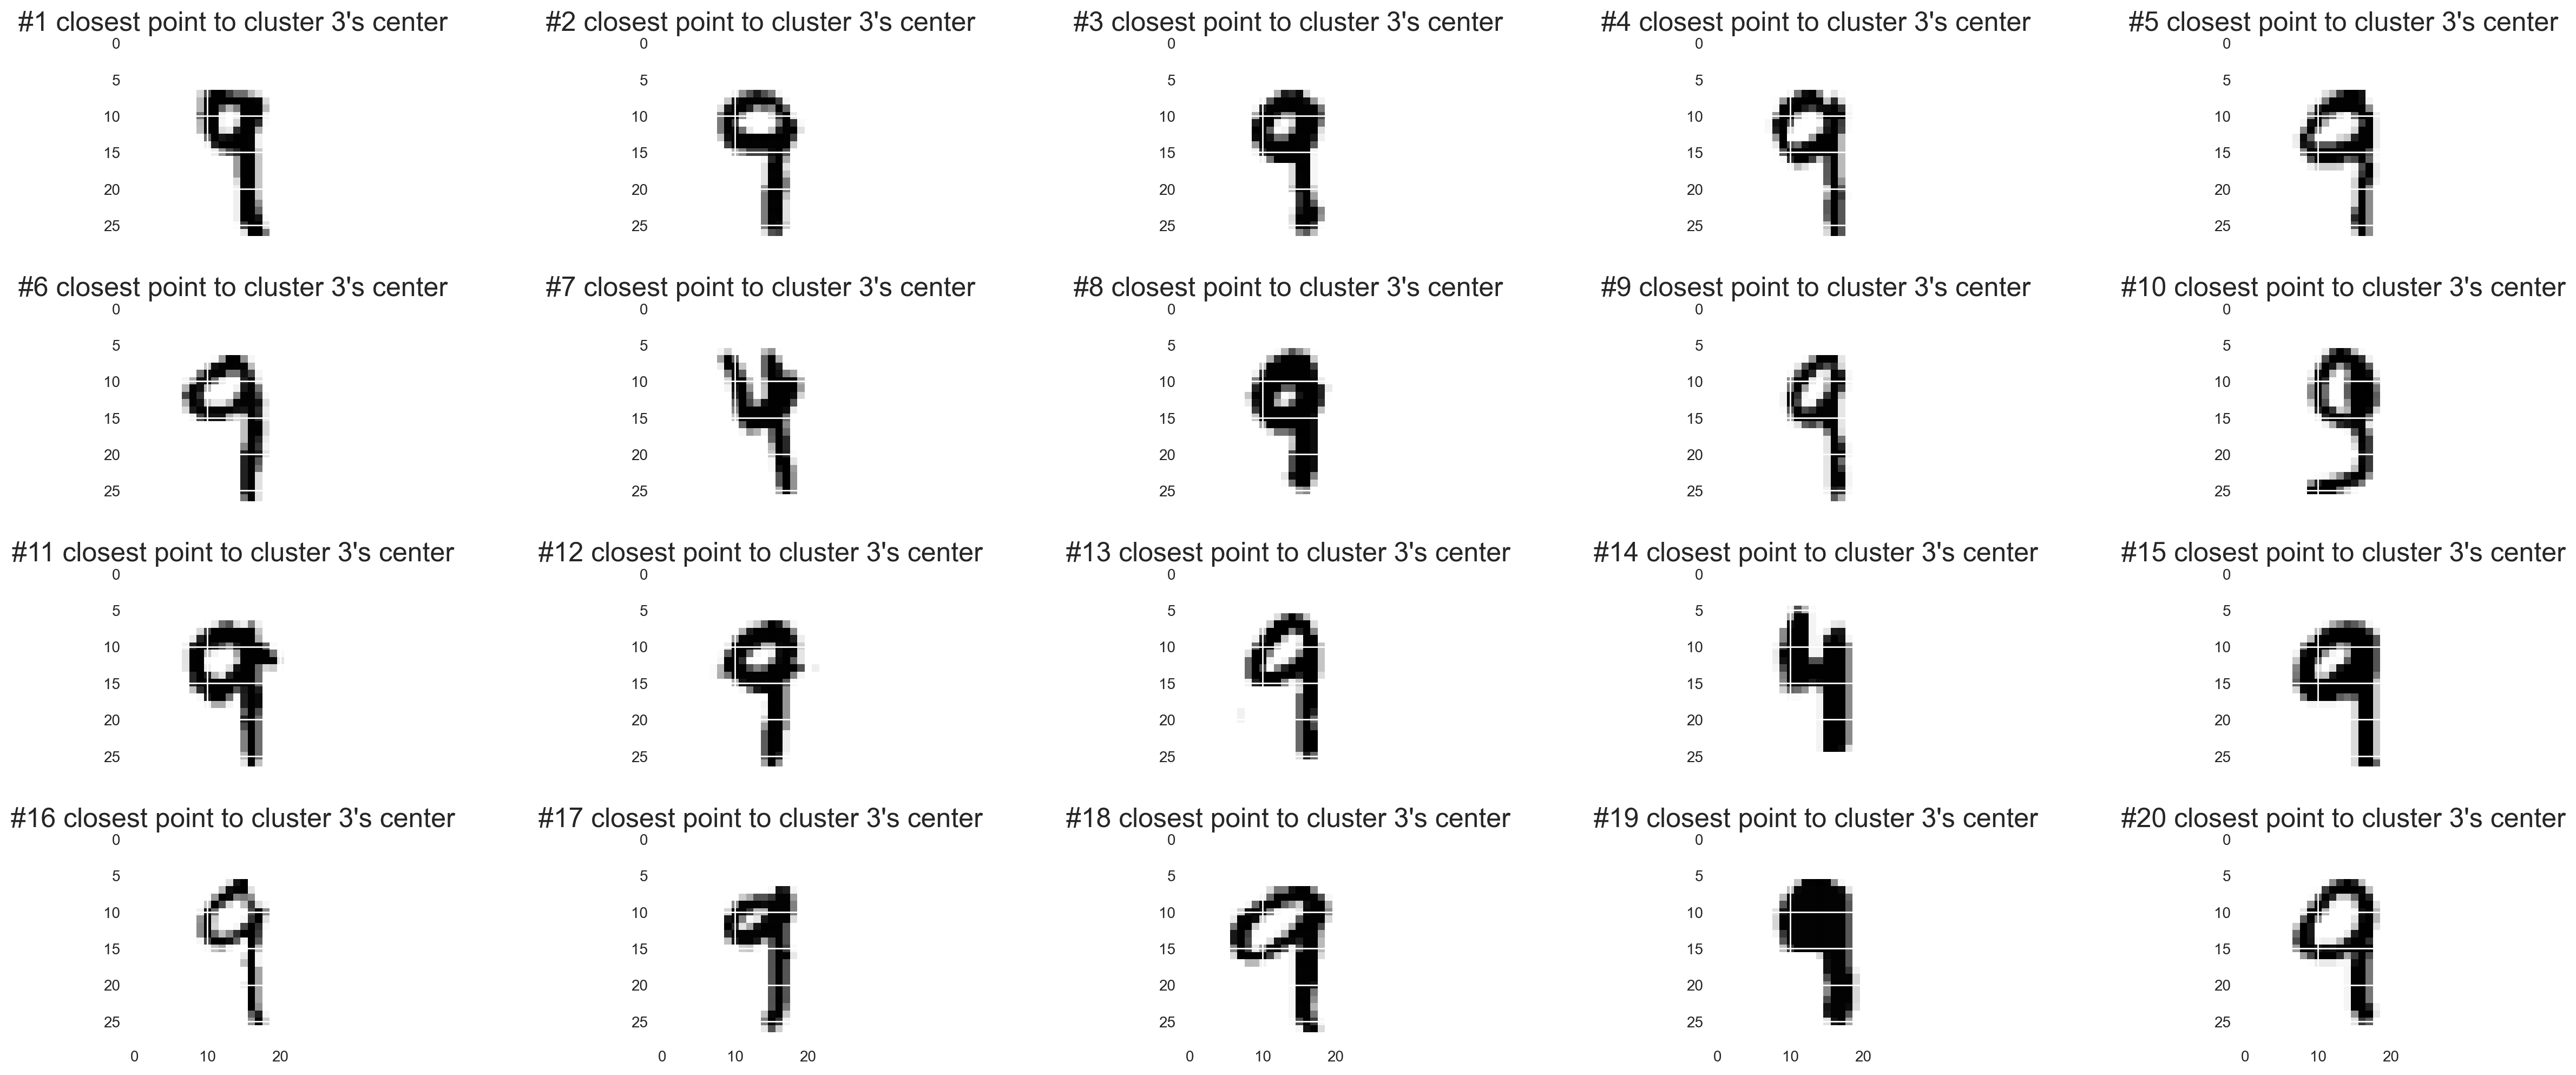

In [33]:
distances = np.array([np.linalg.norm(point - new_kmeans.cluster_centers_[3]) for point in feature_vectors_tsne2d])
sorted_indices = np.argsort(distances)[:20]

fig, axes = plt.subplots(4, 5, figsize=(30, 12), sharex=True)
axes = axes.flatten()
for idx, (dist, point) in enumerate(zip(distances[sorted_indices], X[sorted_indices])):
    ax = axes[idx]
    ax.imshow(point.reshape(28, 28))
    ax.set_title('#' + str(idx + 1) + " closest point to cluster 3's center", fontsize=18)

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # adds some white space between subplots